In [1]:
pip install control

     |████████████████████████████████| 348kB 3.9MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344920 sha256=cef9b61fce88949bba21723b7399da09d45baf45fa9ccc6f22458d4068efedf4
  Stored in directory: /root/.cache/pip/wheels/35/be/ee/081b68ca3e4b2d253fba2f7f7e51960373903fb7b6d13c5532
Successfully built control


In [2]:
pip install slycot

     |████████████████████████████████| 1.6MB 4.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for slycot: filename=slycot-0.4.0-cp37-cp37m-linux_x86_64.whl size=1417831 sha256=a4a4f2c1e73a82c62e42804b24dc3d27c3e3e1a2a53423e8b28bcb7f6fcd16a4
  Stored in directory: /root/.cache/pip/wheels/a2/46/56/f82cbb2fd06556f4f3952a2eb2396e8fd29264fffecbaad3cf
Successfully built slycot


In [3]:
import numpy as np
from numpy.linalg import *
import control
import slycot
from control.matlab import *
import control.modelsimp as msimp
from scipy.linalg import fractional_matrix_power
import matplotlib.pyplot as plt

In [4]:
sys = rss(100, 1)

StateSpace(array([[-4.81587825e+00,  1.96242650e+01, -2.42875213e+01, ...,
        -1.17071013e+02, -8.52252498e+01,  1.91431334e+01],
       [-1.32571457e+00,  3.66142292e+01, -3.50887498e+01, ...,
        -2.02454639e+02, -1.40770422e+02,  3.49339146e+01],
       [-7.94110023e+00,  9.42691183e+01, -8.61447345e+01, ...,
        -5.08999589e+02, -3.51826250e+02,  6.78121988e+01],
       ...,
       [-3.68867600e+00, -7.38659512e+01,  4.64802045e+01, ...,
         3.39710762e+02,  2.55979521e+02, -6.23470121e+01],
       [ 2.75715843e+00,  1.17425631e+02, -9.49350767e+01, ...,
        -6.04985746e+02, -4.49472074e+02,  8.76530535e+01],
       [ 3.88792634e-02, -1.72441688e+02,  1.36205350e+02, ...,
         8.52313643e+02,  6.36741064e+02, -1.28403446e+02]]), array([[ 1.3993276 ],
       [-0.87836966],
       [ 0.99775925],
       [ 0.        ],
       [-0.1551855 ],
       [-1.66851822],
       [-1.32388279],
       [ 0.39735301],
       [-0.        ],
       [-1.41762788],
       [ 1.

In [5]:
Wc = gram(sys,'c') # Controllability Gramian
Wo = gram(sys,'o') # Observability Gramian

# Manually compute transform matrix for balanced Gramians
_,Tu = eig(Wc@Wo)

# Resolve sign ambiguity of eigenvectors
for j in range(Tu.shape[1]):
    if Tu[0,j] < 0:
        Tu[:,j] = -Tu[:,j]
        
Sig_c = inv(Tu) @ Wc @ inv(Tu).T
Sig_o = Tu.T @ Wo @ Tu
Sig_s = fractional_matrix_power(Sig_c,1/4) @ fractional_matrix_power(Sig_o,-1/4)

T = Tu @ Sig_s
Ti = inv(T)

In [6]:
r=5

Psi = T[:,0:r]
Phe = Ti[0:r,:]

Ar = Phe @ sys.A @ Psi
Br = Phe @ sys.B
Cr = sys.C @ Psi
Dr = 0

sysr = ss(Ar,Br,Cr,Dr)

/usr/local/lib/python3.7/dist-packages/numpy/matrixlib/defmatrix.py:128: ComplexWarning: Casting complex values to real discards the imaginary part
  return data.astype(dtype)


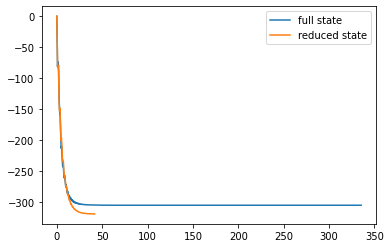

In [7]:
# Comparison of the step responses of the full and reduced systems
y, t = step(sys)
yr, tr = step(sysr)
plt.plot(t.T, y.T,label='full state')
plt.plot(tr.T, yr.T,label='reduced state')
plt.legend()

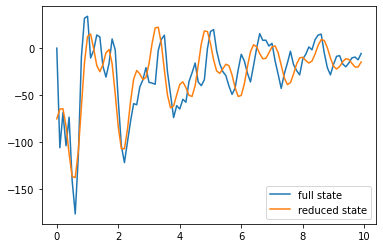

In [8]:
# Comparison of the impulse responses of the full and reduced random systems
t = np.arange(0,10,0.1)
y, t = impulse(sys,t)
yr, t = impulse(sysr,t)
plt.plot(t.T, y.T,label='full state')
plt.plot(t.T, yr.T,label='reduced state')
plt.legend()

In [9]:
sys_balred  = msimp.balred(sys, r, method='truncate')

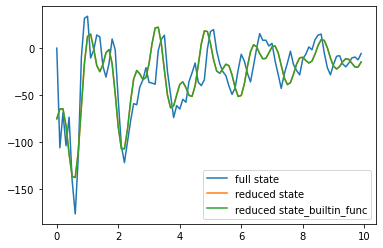

In [10]:
# Comparison of the impulse responses of the full and reduced random systems (using builtin func also)
t = np.arange(0,10,0.1)
y, t = impulse(sys,t)
yr, t = impulse(sysr,t)
y_balred, t = impulse(sys_balred,t)
plt.plot(t.T, y.T,label='full state')
plt.plot(t.T, yr.T,label='reduced state')
plt.plot(t.T, y_balred.T,label='reduced state_builtin_func')
plt.legend()

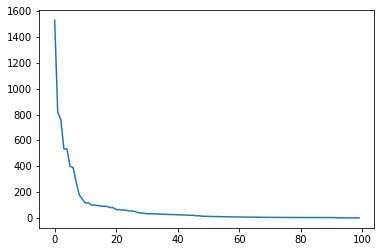

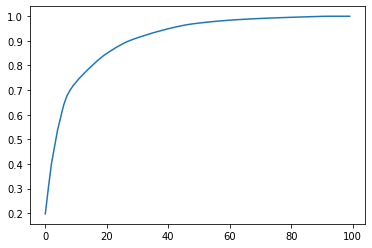

In [11]:
# Plot of Hankel Singular values
from scipy.linalg import hankel
H = hankel(y)
u,s,vt = np.linalg.svd(H)

plt.plot((s))
plt.figure(4)
plt.plot(np.cumsum(s)/sum(s))